In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
train_data = pd.read_csv('data/train.csv')
display(train_data)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


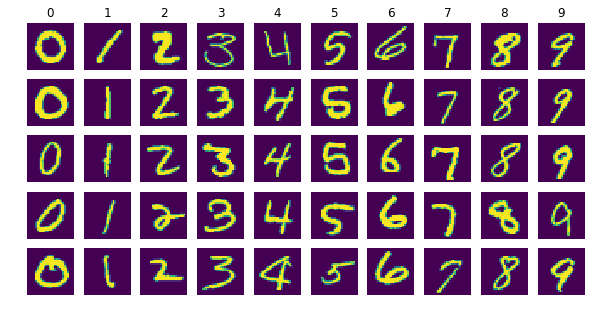

In [111]:
digit_num = 10
samples = 5
plt.gcf().set_size_inches(10, samples)

for i in range(digit_num):
    digits = train_data.loc[train_data['label'] == i].iloc[:, 1:]
    for j in range(samples):
        plt_idx = i + 1 + j * digit_num 
        plt.subplot(samples, digit_num, plt_idx)
        plt.imshow(digits.iloc[j].values.reshape(28, 28))
        plt.axis("off")
        if j == 0:
            plt.title(i)
    
plt.show()